# Implementing and Exploring Variational Autoencoders (VAEs)


## Part 1: Setup
### Import necessary libraries

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### Load MNIST dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Part 2: Explore and visualize data
## Visualize samples

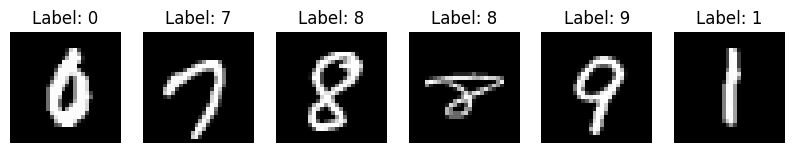

In [3]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')
plt.show()

## Part 3: Implement VAE

In [ ]:
import torch
from torch import nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )
        self.mu = nn.Linear(400, latent_dim)
        self.log_var = nn.Linear(400, latent_dim)

    def forward(self, x):
        h = self.enc(x)
        return self.mu(h), self.log_var(h)

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.dec(z)

class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std  

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var


A Variational Autoencoder loss typically has two components:
  - Reconstruction loss
  - Measures how accurately the model reconstructs the input.
  - Typically binary cross-entropy for MNIST (pixel intensities are between 0 and 1). Also consider MSE.

KL Divergence loss
  - Measures how much the learned latent distribution deviates from a standard Gaussian distribution.
  - Ensures latent space regularity.

In [ ]:
def vae_loss(recon_x, x, mu, log_var):
    # Reconstruction Loss:
    # Measures how accurately the decoded output matches the original input.
    recon_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL Divergence Loss:
    # Measures how much the learned latent distribution deviates
    # from a standard Gaussian distribution (prior).
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss combines both terms
    loss = recon_loss + kl_loss

    return loss, recon_loss, kl_loss


In [7]:
# The code runs faster if you run on GPU. Select Runtime -> Change runtime type -> T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Part 4: Train the model



In [8]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_losses = []
kl_losses = []
recon_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_kl = 0
    total_recon = 0
    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        optimizer.zero_grad()

        # Compute model predictions
        recon_x, mu, log_var = model(x)

        # Compute losses
        loss, recon_loss, kl_loss = vae_loss(recon_x, x, mu, log_var)

        # Run backward and optimizer
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    # Compute average loss and store it
    train_losses.append(total_loss / len(train_loader))
    recon_losses.append(total_recon / len(train_loader))
    kl_losses.append(total_kl / len(train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')


Epoch [1/50], Loss: 24390.4477
Epoch [2/50], Loss: 21457.1007
Epoch [3/50], Loss: 20808.3913
Epoch [4/50], Loss: 20461.0651
Epoch [5/50], Loss: 20226.9435
Epoch [6/50], Loss: 20049.2672
Epoch [7/50], Loss: 19905.1100
Epoch [8/50], Loss: 19792.5496
Epoch [9/50], Loss: 19688.6161
Epoch [10/50], Loss: 19600.1442
Epoch [11/50], Loss: 19521.1929
Epoch [12/50], Loss: 19456.8836
Epoch [13/50], Loss: 19393.6822
Epoch [14/50], Loss: 19334.1519
Epoch [15/50], Loss: 19278.3629
Epoch [16/50], Loss: 19235.3951
Epoch [17/50], Loss: 19193.6797
Epoch [18/50], Loss: 19154.4162
Epoch [19/50], Loss: 19122.5880
Epoch [20/50], Loss: 19085.9313
Epoch [21/50], Loss: 19049.2626
Epoch [22/50], Loss: 19024.8662
Epoch [23/50], Loss: 18992.1168
Epoch [24/50], Loss: 18959.8582
Epoch [25/50], Loss: 18940.9503
Epoch [26/50], Loss: 18921.6032
Epoch [27/50], Loss: 18898.0491
Epoch [28/50], Loss: 18874.9891
Epoch [29/50], Loss: 18852.3600
Epoch [30/50], Loss: 18831.3204
Epoch [31/50], Loss: 18809.7039
Epoch [32/50], Lo

# Part 5: Analyze Results

#### 1. Plot the total training loss (average per epoch).

#### 2. Plot the reconstruction loss and KL divergence loss separately on the same plot (clearly labeled).

#### 3. Did the model converge? Which loss dominates and why?


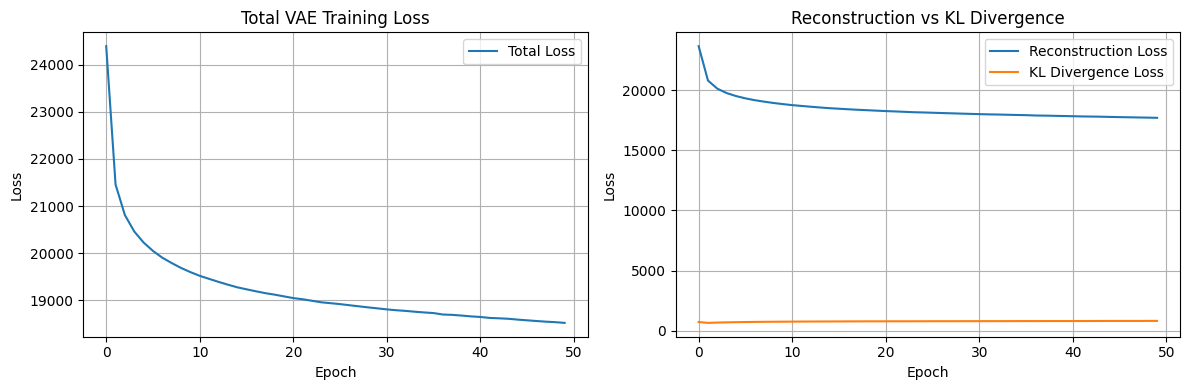

In [9]:
# Assume train_losses, recon_losses, kl_losses were stored during training

plt.figure(figsize=(12,4))

# Plot total training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Total Loss')
plt.title('Total VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Plot Reconstruction and KL divergence separately
plt.subplot(1, 2, 2)
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence Loss')
plt.title('Reconstruction vs KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


#### We can observe that the total training loss has reached a relative convergence. Also as the scale of the KL loss is much smaller comparing to the reconstruction loss, the model has paid much more attention to decreasing the reconstruction loss and the decrease in reconstruction loss is significantly more than the KL loss.

# Part 6: Generate and visualize samples

 - Generate and visualize at least 16 samples from random latent vectors.
 - Comment on the sample qualities
 - Is there any way that you can increase the sample qualities?
    - Can you make changes to the architecture to improve the quality?
    - Can you change the reconstruction loss to improve the quality?

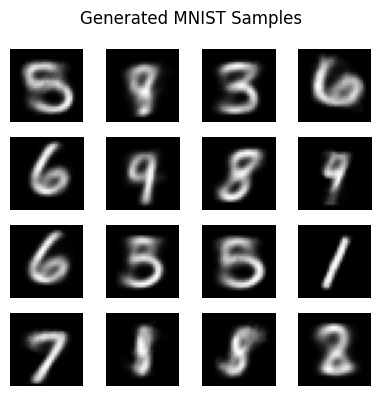

In [10]:
with torch.no_grad():
    # Generate random latent vectors
    z = torch.randn(16, model.encoder.mu.out_features).to(device)
    samples = model.decoder(z).cpu()

fig, axes = plt.subplots(4,4, figsize=(4,4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i].view(28,28), cmap='gray')
    ax.axis('off')

plt.suptitle('Generated MNIST Samples')
plt.tight_layout()
plt.show()


#### We can see that although the generated samples are not fully clear, they are still similar to the original data and the digits are recognizable. </br>
#### By increasing the dimension of the latent space, we would be able to capture more information about the data so the generated samples would be more clear. Considering the fact that our data points are binary, binary cross entropy is the best choice for reconstruction loss.

# Part 7: Latent Space Visualization

  - Decode all the items in the test set then visualize the encodings with scatterplot
  - Clearly label the plot with digit labels.
  - Interpret how well-separated or clustered digits appear.



(10000, 2) (10000, 2) (10000,)


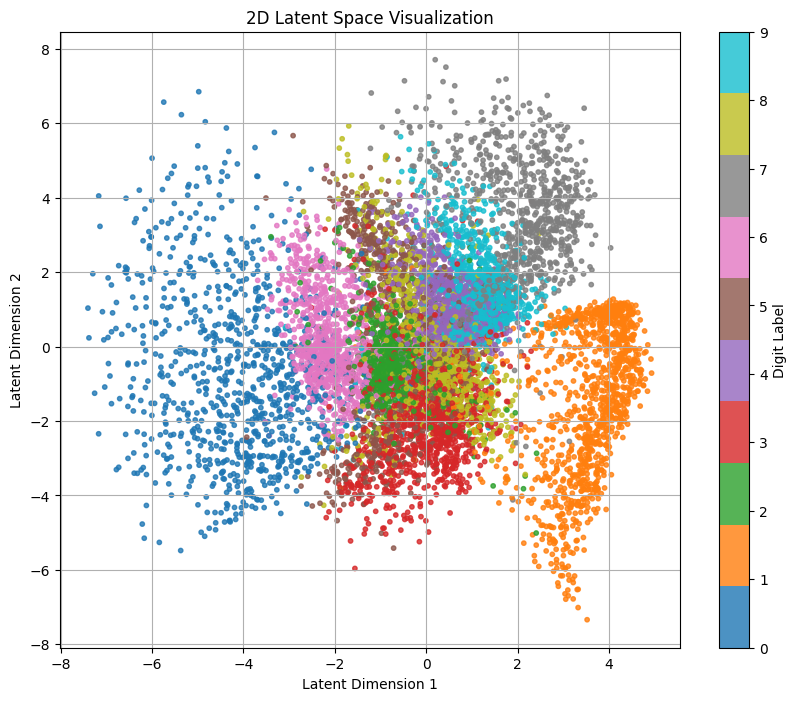

In [ ]:
model.eval()
mu_list, logvar_list, labels_list = [], [], []

with torch.no_grad():
    for x, labels in test_loader:
        x = x.view(-1, 784).to(device)  # Correct shape for convolutional model
        mu, logvar = model.encoder.forward(x)
      
        mu_list.append(mu.cpu())
        logvar_list.append(logvar.cpu())
        labels_list.append(labels.cpu())

mu_all = torch.cat(mu_list, dim=0).numpy()
labels_all = torch.cat(labels_list, dim=0).numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    mu_all[:, 0],
    mu_all[:, 1],
    c=labels_all,
    cmap='tab10',
    s=10,
    alpha=0.8
)
plt.colorbar(scatter, label="Digit Label")
plt.title("2D Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.grid(True)
plt.show()

# Part 8: Latent Space Interpolation

  - Perform interpolation between pairs of test samples in the latent space.
  - Consider two samples—for example, one labeled '7' and the other '2'. Encode both samples, then interpolate between their encoded representations.
  - Decode interpolations and visualize transitions clearly.
  - Comment on smoothness and interpretability of transitions.

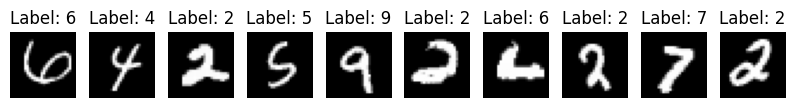

In [33]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    axes[i].imshow(images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')
plt.show()

We choose 3rd and 9th samples from this batch which are the images of the digits 2 and 7 respectively.

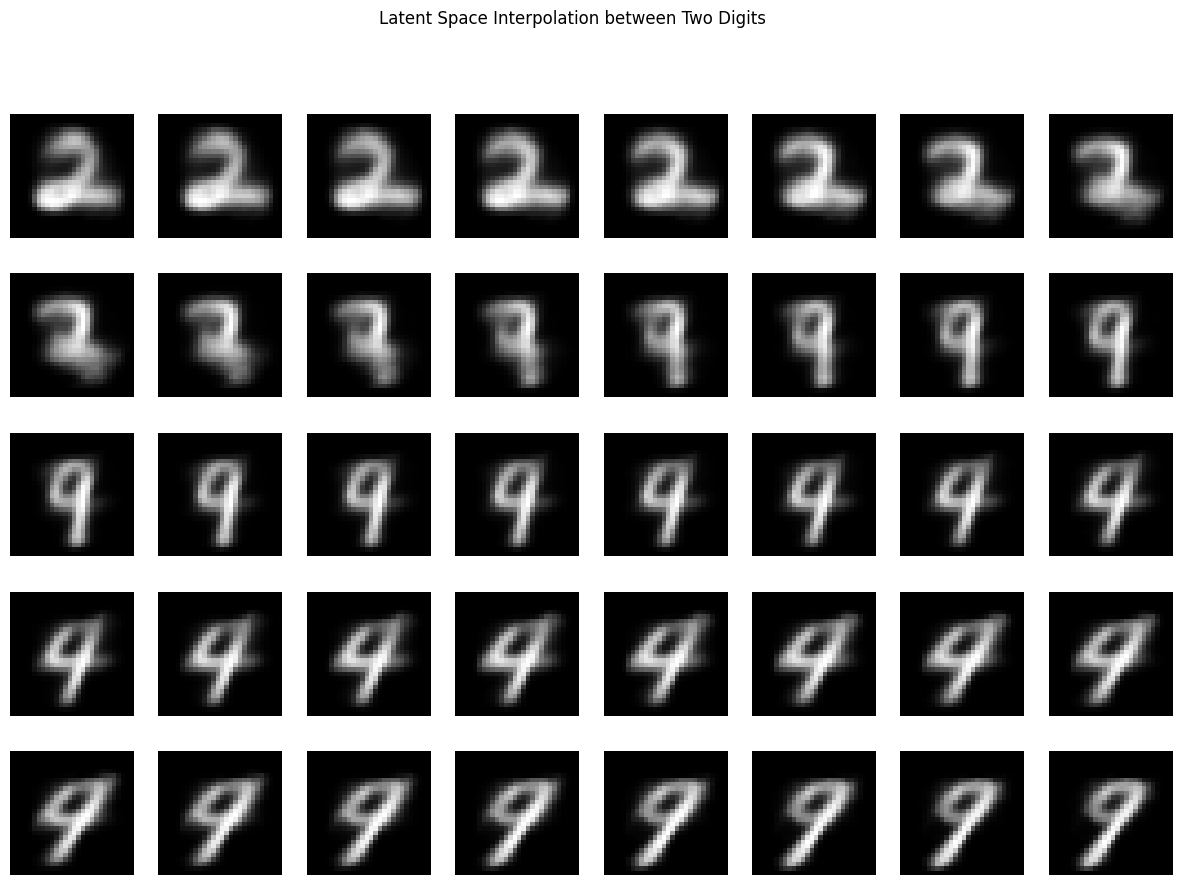

In [35]:
def interpolate(latent1, latent2, steps):
    ratios = torch.linspace(0, 1, steps).unsqueeze(1).to(latent1.device)
    interpolated = latent1 * (1 - ratios) + latent2 * ratios
    return interpolated

num_steps = 40

with torch.no_grad():
    # Select two random images
    x1 = images[2].squeeze().view(1, 784).to(device) # select a sample from dataset
    x2 = images[8].squeeze().view(1, 784).to(device) # select another sample from dataset

    mu1, logvar1 = model.encoder(x1)
    mu2, logvar2 = model.encoder(x2)

# interpolate both if needed
    mu_interp = interpolate(mu1, mu2, num_steps)
    
    decoded_samples = model.decoder(mu_interp).cpu()

fig, axes = plt.subplots(5, 8, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(decoded_samples[i].view(28,28), cmap='gray')
    ax.axis('off')

plt.suptitle('Latent Space Interpolation between Two Digits')
plt.show()

#### The transitions through the latent space are pretty smooth. Also judging by the images derived while interpolating, we can say the the model has interpreted that the digit "4" is somewhere between digits "2" and "7" as some of the middle images look like a "4".